In [1]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from explicit_functions import dual_control, upstream_repression, no_control, downstream_activation, loss_biological

In [2]:
da = pd.read_csv('da_background.csv')
da['circuit'] = 'Downstream Activation'
ur = pd.read_csv('ur_background.csv')
ur['circuit'] = 'Upstream Repression'
nc = pd.read_csv('nc_background.csv')
nc['circuit'] = 'No Control'
dc = pd.read_csv('dc_background.csv')
dc['circuit'] = 'Dual Control'


perturbed_dc = pd.read_csv('dc_perturbation_grid.csv')
perturbed_dc['circuit'] = 'Dual Control'
perturbed_da = pd.read_csv('da_perturbation_grid.csv')
perturbed_da['circuit'] = 'Downstream Activation'
perturbed_nc = pd.read_csv('nc_perturbation_grid.csv')
perturbed_nc['circuit'] = 'No Control'
perturbed_ur = pd.read_csv('ur_perturbation_grid.csv')
perturbed_ur['circuit'] = 'Upstream Repression'

perturbed_dc1 = pd.read_csv('dc_perturbation_grid_1s.csv')
perturbed_dc1['circuit'] = 'Dual Control'
perturbed_da1 = pd.read_csv('da_perturbation_grid_1s.csv')
perturbed_da1['circuit'] = 'Downstream Activation'
perturbed_nc1 = pd.read_csv('nc_perturbation_grid_1s.csv')
perturbed_nc1['circuit'] = 'No Control'
perturbed_ur1 = pd.read_csv('ur_perturbation_grid_1s.csv')
perturbed_ur1['circuit'] = 'Upstream Repression'

perturbed = pd.concat([perturbed_dc, perturbed_da, perturbed_nc, perturbed_ur, perturbed_dc1, perturbed_da1, perturbed_nc1, perturbed_ur1])
perturbed['perturbed'] = True
background = pd.concat([da, ur, nc, dc])
background['perturbed'] = False
combined = pd.concat([perturbed, background])
combined = combined.loc[combined.num_iters > 150]
combined['km_perturb'] = combined.km_perturb.fillna(1)
combined['kc_perturb'] = combined.kc_perturb.fillna(1)

#combined.to_csv('perturb_viz_data_with_background.csv')

In [21]:
perturbed_dc10 = pd.read_csv('dc_10kperturbs.csv')
perturbed_dc10['circuit'] = 'Dual Control'
perturbed_dc10['perturbed'] = True

perturbed_nc10 = pd.read_csv('nc_10kperturbs.csv')
perturbed_nc10['circuit'] = 'No Control'
perturbed_nc10['perturbed'] = True

In [22]:
combined_dc = pd.concat([dc, perturbed_dc10])
combined_nc = pd.concat([nc, perturbed_nc10])
combined = pd.concat([combined_dc, combined_nc])

In [24]:

features = ['k1', 'k2', 'theta1', 'theta2']

x = combined.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
combined['pc1'] = principalComponents[:,0]
combined['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
combined['tsne1'] = tsne_results[:,0]
combined['tsne2'] = tsne_results[:,1]

C:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13322 samples in 0.017s...
[t-SNE] Computed neighbors for 13322 samples in 0.544s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13322
[t-SNE] Computed conditional probabilities for sample 2000 / 13322
[t-SNE] Computed conditional probabilities for sample 3000 / 13322
[t-SNE] Computed conditional probabilities for sample 4000 / 13322
[t-SNE] Computed conditional probabilities for sample 5000 / 13322
[t-SNE] Computed conditional probabilities for sample 6000 / 13322
[t-SNE] Computed conditional probabilities for sample 7000 / 13322
[t-SNE] Computed conditional probabilities for sample 8000 / 13322
[t-SNE] Computed conditional probabilities for sample 9000 / 13322
[t-SNE] Computed conditional probabilities for sample 10000 / 13322
[t-SNE] Computed conditional probabilities for sample 11000 / 13322
[t-SNE] Computed conditional probabilities for sample 12000 / 13322
[t-SNE] Computed conditional probabilities for sa

C:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.965240
[t-SNE] KL divergence after 300 iterations: 2.657958


In [47]:
background = combined.loc[combined.perturbed != True].reset_index(drop=True)
perturbed = combined.loc[combined.perturbed == True].reset_index(drop=True)

Text(0, 0.5, 'Principal Component 2')

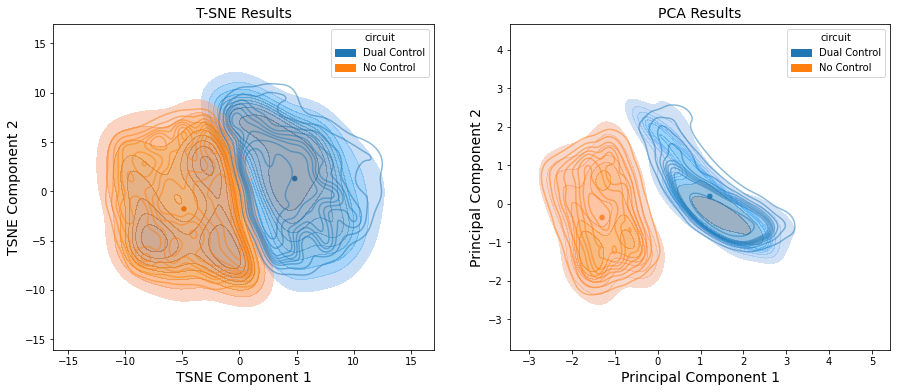

In [48]:
#Compute mean background losses by circuit type
means = background.groupby('circuit').mean()
alpha = 1
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
#sns.scatterplot(x='pc1', y='pc2', data = finalDf, hue='loss', ax=ax)
sns.scatterplot(x="tsne1", y="tsne2", data=means, hue='circuit', alpha=alpha, ax=ax)
sns.kdeplot(
    data=perturbed,
    x="tsne1",
    y="tsne2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)

sns.kdeplot(
    data=background,
    x="tsne1",
    y="tsne2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5, fill=True
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
sns.scatterplot(x="pc1", y="pc2", data=means, hue='circuit', alpha=alpha, ax=ax)
sns.kdeplot(
    data=perturbed,
    x="pc1",
    y="pc2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)

sns.kdeplot(
    data=background,
    x="pc1",
    y="pc2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5, fill=True
)

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
#fig.savefig('TSNE_PCA_100background_GSperturbations.png')

In [49]:
perturbed = combined.loc[combined.perturbed == True].sort_values(by='circuit').reset_index(drop=True)

#Normalize scaled perturbations
perturbed['normalized_km1_perturb'] = [1-(perturbed.km1_perturb[i] - perturbed.km1_perturb.min())/(perturbed.km1_perturb.max() - perturbed.km1_perturb.min()) for i in range(len(perturbed))] 
perturbed['normalized_kc1_perturb'] = [1-(perturbed.kc1_perturb[i] - perturbed.kc1_perturb.min())/(perturbed.kc1_perturb.max() - perturbed.kc1_perturb.min()) for i in range(len(perturbed))] 
perturbed['normalized_km2_perturb'] = [1-(perturbed.km2_perturb[i] - perturbed.km2_perturb.min())/(perturbed.km2_perturb.max() - perturbed.km2_perturb.min()) for i in range(len(perturbed))] 
perturbed['normalized_kc2_perturb'] = [1-(perturbed.kc2_perturb[i] - perturbed.kc2_perturb.min())/(perturbed.kc2_perturb.max() - perturbed.kc2_perturb.min()) for i in range(len(perturbed))] 

perturbed['sum_perturb'] = [(perturbed.normalized_km1_perturb[i] + perturbed.normalized_kc1_perturb[i] + perturbed.normalized_km2_perturb[i] + perturbed.normalized_kc2_perturb[i])  for i in range(len(perturbed))] 
perturbed['normalized_perturbs'] = [ (perturbed.sum_perturb[i] - perturbed.sum_perturb.min())/(perturbed.sum_perturb.max() - perturbed.sum_perturb.min())  for i in range(len(perturbed))] 


Text(0, 0.5, 'TSNE Component 2')

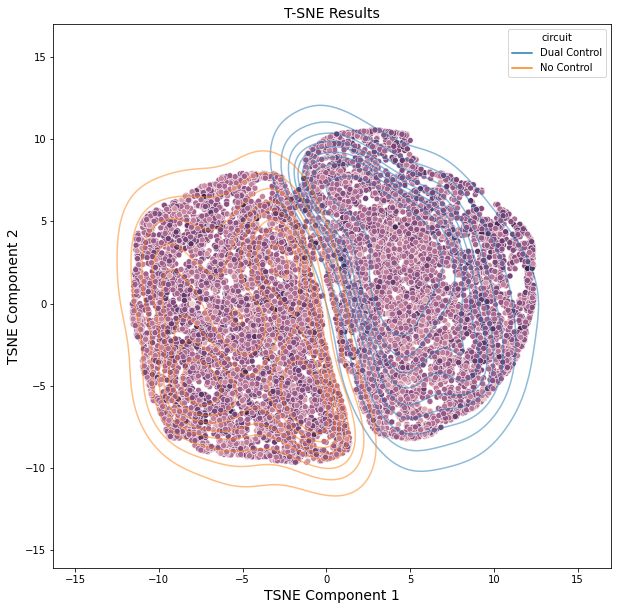

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

endpoint = 'T-SNE Results'
ax = axs
#sns.scatterplot(x='pc1', y='pc2', data = finalDf, hue='loss', ax=ax)
sns.scatterplot(x="tsne1", y="tsne2", data=perturbed, hue='normalized_perturbs', alpha=alpha, ax=ax)
sns.kdeplot(
    data=background,
    x="tsne1",
    y="tsne2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)

C:\Users\CHARLO~1\AppData\Local\Temp/ipykernel_31208/3720015912.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  d = perturbed.loc[perturbed.kc1_perturb == kc].loc[perturbed.km1_perturb == km].reset_index(drop=True).loss[0] - background.loc[background.circuit == circuit].mean().loss
C:\Users\CHARLO~1\AppData\Local\Temp/ipykernel_31208/3720015912.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  d = perturbed.loc[perturbed.kc2_perturb == kc].loc[perturbed.km2_perturb == km].reset_index(drop=True).loss[0] - background.loc[background.circuit ==circuit].mean().loss


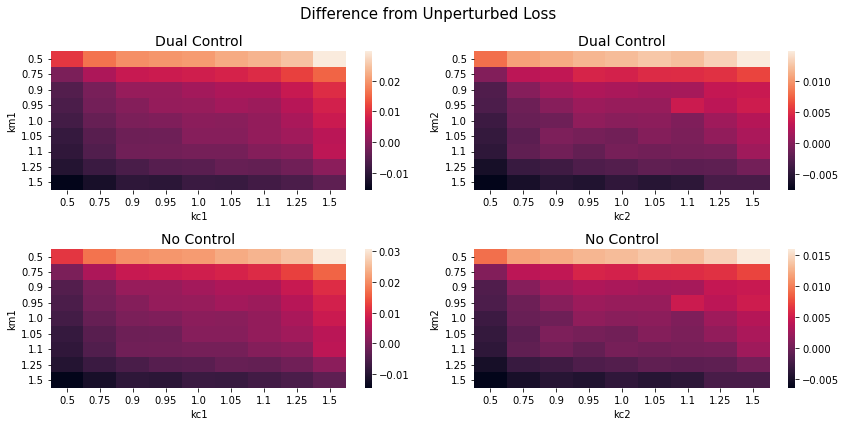

In [60]:
def get_heatmap_data(circuit, perturbed):
    circuit_df = perturbed.loc[perturbed.circuit == circuit]
    kcs = perturbed.kc1_perturb.sort_values().unique()
    kms = perturbed.km1_perturb.sort_values().unique()

    heatmap_data = np.zeros([len(kcs), len(kms)])
    for i in range(len(kcs)):
        for j in range(len(kms)):
            kc = kcs[i]
            km = kms[j]
            d = perturbed.loc[perturbed.kc1_perturb == kc].loc[perturbed.km1_perturb == km].reset_index(drop=True).loss[0] - background.loc[background.circuit == circuit].mean().loss
            heatmap_data[i][j] = d
    heatmap_data = pd.DataFrame(heatmap_data, index=kcs, columns=kms)
    return heatmap_data

def get_heatmap_data2(circuit, perturbed):
    circuit_df = perturbed.loc[perturbed.circuit == circuit]
    kcs = perturbed.kc2_perturb.sort_values().unique()
    kms = perturbed.km2_perturb.sort_values().unique()

    heatmap_data = np.zeros([len(kcs), len(kms)])
    for i in range(len(kcs)):
        for j in range(len(kms)):
            kc = kcs[i]
            km = kms[j]
            d = perturbed.loc[perturbed.kc2_perturb == kc].loc[perturbed.km2_perturb == km].reset_index(drop=True).loss[0] - background.loc[background.circuit ==circuit].mean().loss
            heatmap_data[i][j] = d
    heatmap_data = pd.DataFrame(heatmap_data, index=kcs, columns=kms)
    return heatmap_data

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

endpoint = 'Dual Control'
ax = axs[0][0]
ax = sns.heatmap(get_heatmap_data(endpoint, perturbed.loc[perturbed.km2_perturb == 1].loc[perturbed.kc2_perturb ==1]), ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('kc1')
ax.set_ylabel('km1')

endpoint = 'No Control'
ax = axs[1][0]
ax = sns.heatmap(get_heatmap_data(endpoint, perturbed.loc[perturbed.km2_perturb == 1].loc[perturbed.kc2_perturb ==1]), ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('kc1')
ax.set_ylabel('km1')

endpoint = 'Dual Control'
ax = axs[0][1]
ax = sns.heatmap(get_heatmap_data2(endpoint, perturbed.loc[perturbed.km1_perturb == 1].loc[perturbed.kc1_perturb ==1]), ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('kc2')
ax.set_ylabel('km2')

endpoint = 'No Control'
ax = axs[1][1]
ax = sns.heatmap(get_heatmap_data2(endpoint, perturbed.loc[perturbed.km1_perturb == 1].loc[perturbed.kc1_perturb ==1]), ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('kc2')
ax.set_ylabel('km2')

fig.suptitle('Difference from Unperturbed Loss', fontsize=15)
fig.tight_layout()

C:\Users\CHARLO~1\AppData\Local\Temp/ipykernel_31208/3910570059.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  d = circuit_df.loc[circuit_df.kc1_perturb == kc].loc[circuit_df.km1_perturb == km].reset_index(drop=True).loss[0] - background.loc[background.circuit == circuit].mean().loss
C:\Users\CHARLO~1\AppData\Local\Temp/ipykernel_31208/3910570059.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  d = circuit_df.loc[circuit_df.kc2_perturb == kc].loc[circuit_df.km2_perturb == km].reset_index(drop=True).loss[0] - background.loc[background.circuit ==circuit].mean().loss


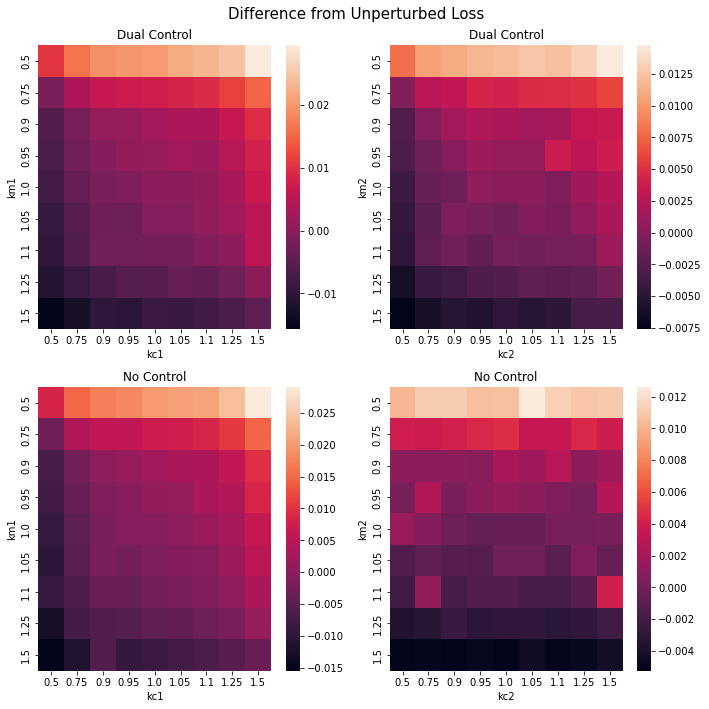

In [67]:
def get_heatmap_data(circuit, perturbed):
    circuit_df = perturbed.loc[perturbed.circuit == circuit]
    kcs = perturbed.kc1_perturb.sort_values().unique()
    kms = perturbed.km1_perturb.sort_values().unique()

    heatmap_data = np.zeros([len(kcs), len(kms)])
    for i in range(len(kcs)):
        for j in range(len(kms)):
            kc = kcs[i]
            km = kms[j]
            d = circuit_df.loc[circuit_df.kc1_perturb == kc].loc[circuit_df.km1_perturb == km].reset_index(drop=True).loss[0] - background.loc[background.circuit == circuit].mean().loss
            heatmap_data[i][j] = d
    heatmap_data = pd.DataFrame(heatmap_data, index=kcs, columns=kms)
    return heatmap_data

def get_heatmap_data2(circuit, perturbed):
    circuit_df = perturbed.loc[perturbed.circuit == circuit]
    kcs = perturbed.kc2_perturb.sort_values().unique()
    kms = perturbed.km2_perturb.sort_values().unique()

    heatmap_data = np.zeros([len(kcs), len(kms)])
    for i in range(len(kcs)):
        for j in range(len(kms)):
            kc = kcs[i]
            km = kms[j]
            d = circuit_df.loc[circuit_df.kc2_perturb == kc].loc[circuit_df.km2_perturb == km].reset_index(drop=True).loss[0] - background.loc[background.circuit ==circuit].mean().loss
            heatmap_data[i][j] = d
    heatmap_data = pd.DataFrame(heatmap_data, index=kcs, columns=kms)
    return heatmap_data

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

endpoint = 'Dual Control'
ax = axs[0][0]
ax = sns.heatmap(get_heatmap_data(endpoint, perturbed.loc[perturbed.km2_perturb == 1].loc[perturbed.kc2_perturb ==1]), ax=ax)
ax.set_title(f'{endpoint}', fontsize=12)
ax.set_xlabel('kc1')
ax.set_ylabel('km1')

endpoint = 'No Control'
ax = axs[1][0]
ax = sns.heatmap(get_heatmap_data(endpoint, perturbed.loc[perturbed.km2_perturb == 1].loc[perturbed.kc2_perturb ==1]), ax=ax)
ax.set_title(f'{endpoint}', fontsize=12)
ax.set_xlabel('kc1')
ax.set_ylabel('km1')

endpoint = 'Dual Control'
ax = axs[0][1]
ax = sns.heatmap(get_heatmap_data2(endpoint, perturbed.loc[perturbed.km1_perturb == 1].loc[perturbed.kc1_perturb ==1]), ax=ax)
ax.set_title(f'{endpoint}', fontsize=12)
ax.set_xlabel('kc2')
ax.set_ylabel('km2')

endpoint = 'No Control'
ax = axs[1][1]
ax = sns.heatmap(get_heatmap_data2(endpoint, perturbed.loc[perturbed.km1_perturb == 1].loc[perturbed.kc1_perturb ==1]), ax=ax)
ax.set_title(f'{endpoint}', fontsize=12)
ax.set_xlabel('kc2')
ax.set_ylabel('km2')

fig.suptitle('Difference from Unperturbed Loss', fontsize=15)
fig.tight_layout()

In [69]:
import GPyOpt
from numpy.random import seed
seed(123)

objective_true  = GPyOpt.objective_examples.experiments2d.branin()                 # true function
objective_noisy = GPyOpt.objective_examples.experiments2d.branin(sd = 0.1)         # noisy version
bounds = objective_noisy.bounds

domain = [{'name': 'var_1', 'type': 'continuous', 'domain': bounds[0]}, ## use default bounds
          {'name': 'var_2', 'type': 'continuous', 'domain': bounds[1]}]

batch_size = 4
num_cores = 4

BO_demo_parallel = GPyOpt.methods.BayesianOptimization(f=objective_noisy.f,
                                            domain = domain,
                                            acquisition_type = 'EI',
                                            normalize_Y = True,
                                            initial_design_numdata = 10,
                                            evaluator_type = 'local_penalization',
                                            batch_size = batch_size,
                                            num_cores = num_cores,
                                            acquisition_jitter = 0)

Error in parallel computation. Fall back to single process!
